<a href="https://colab.research.google.com/github/Dhanraj7573/Python-Projects/blob/main/Montecarlomodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
pip install yfinance pandas numpy matplotlib


=== Results ===
Mode: t
Tickers: ['SPY', 'AGG']
Weights: [0.7 0.3]
Horizon: 3 years (756 trading days), Sims: 5000
Start value: 10,000  Goal: 15,000
prob_loss_end     : 10.84%
prob_goal_end     : 2.84%
prob_goal_anytime : 3.94%
terminal_p5       : 9,473
terminal_median   : 11,724
terminal_p95      : 14,489


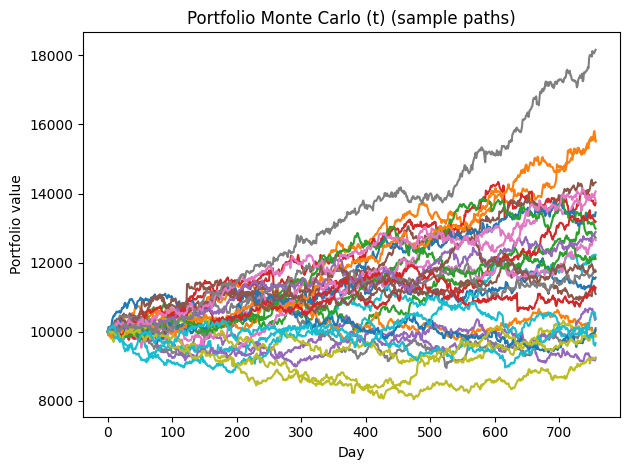

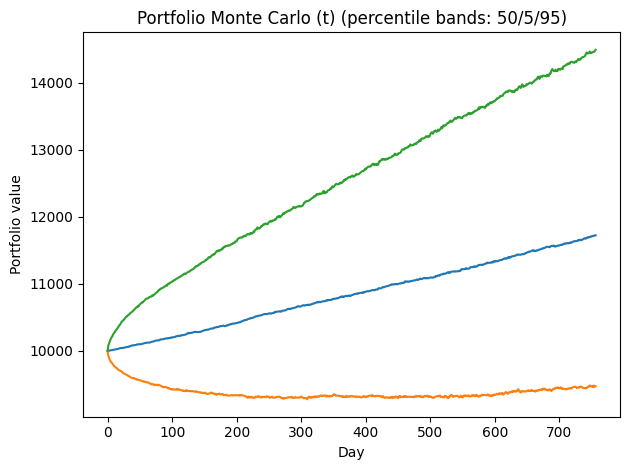

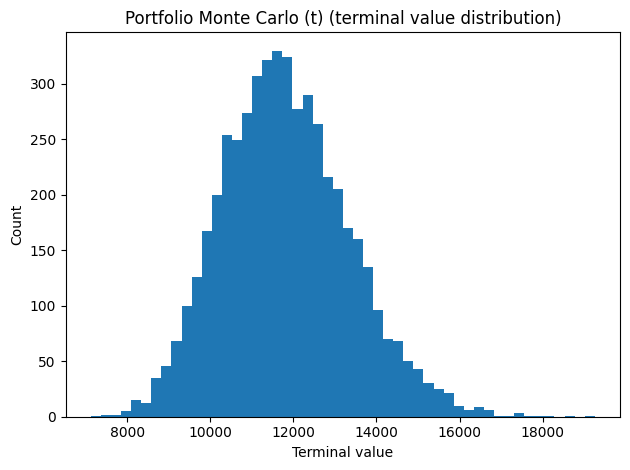

In [21]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Helpers: data + estimation
def get_log_returns(tickers, start="2018-01-01", end=None):
    px = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)["Close"]
    if isinstance(px, pd.Series):
        px = px.to_frame()
    px = px.dropna(how="all")
    px = px.dropna(axis=1, how="any")  # keep tickers with full history in window
    rets = np.log(px / px.shift(1)).dropna()
    return rets

def annualize(mu_daily, cov_daily, trading_days=252):
    mu_ann = mu_daily * trading_days
    cov_ann = cov_daily * trading_days
    return mu_ann, cov_ann

# Simulation engines
def simulate_mvn_log_returns(rng, mu_daily, cov_daily, n_sims, n_days):
    # shape: (n_sims, n_days, n_assets)
    return rng.multivariate_normal(mean=mu_daily, cov=cov_daily, size=(n_sims, n_days))

def simulate_mvt_log_returns(rng, mu_daily, cov_daily, n_sims, n_days, df=5):
    """
    Multivariate t via scale-mixture:
      r = mu + z / sqrt(u/df)
      z ~ N(0, Sigma), u ~ ChiSquare(df)
    Important: Cov(t) = df/(df-2) * Sigma for df>2
    So choose Sigma = cov_daily * (df-2)/df to match desired covariance.
    """
    if df <= 2:
        raise ValueError("df must be > 2 for finite covariance.")
    sigma = cov_daily * (df - 2) / df
    z = rng.multivariate_normal(mean=np.zeros(len(mu_daily)), cov=sigma, size=(n_sims, n_days))
    u = rng.chisquare(df, size=(n_sims, n_days, 1))
    return mu_daily + z / np.sqrt(u / df)

def simulate_regime_switching(
    rng,
    mu_bull, cov_bull,
    mu_bear, cov_bear,
    n_sims, n_days,
    p00=0.97, p11=0.90
):
    """
    2-state Markov chain:
      state 0 = bull, state 1 = bear
    Transitions:
      P(0->0)=p00, P(0->1)=1-p00
      P(1->1)=p11, P(1->0)=1-p11
    """
    n_assets = len(mu_bull)
    states = np.zeros((n_sims, n_days), dtype=np.int8)  # start in bull (0)

    # simulate states day by day (vectorized over sims)
    for t in range(1, n_days):
        prev = states[:, t-1]
        u = rng.random(n_sims)
        # if prev=0: switch to 1 when u > p00
        # if prev=1: stay in 1 when u < p11 else switch to 0
        states[:, t] = np.where(
            prev == 0,
            (u > p00).astype(np.int8),
            (u < p11).astype(np.int8)
        )

    # now sample returns conditional on state, day by day (still vectorized over sims)
    rets = np.empty((n_sims, n_days, n_assets), dtype=float)
    for t in range(n_days):
        mask_bear = states[:, t] == 1
        n_bear = int(mask_bear.sum())
        n_bull = n_sims - n_bear

        if n_bull > 0:
            rets[~mask_bear, t, :] = rng.multivariate_normal(mu_bull, cov_bull, size=n_bull)
        if n_bear > 0:
            rets[mask_bear, t, :] = rng.multivariate_normal(mu_bear, cov_bear, size=n_bear)

    return rets, states

# Portfolio path builder
def build_portfolio_paths(log_returns_3d, weights, v0=10_000):
    """
    log_returns_3d: (n_sims, n_days, n_assets) log returns
    weights: (n_assets,)
    Assumes continuous rebalancing to fixed weights (common in Monte Carlo demos).
    """
    w = np.asarray(weights, dtype=float)
    w = w / w.sum()
    port_log = np.einsum("sda,a->sd", log_returns_3d, w)  # (n_sims, n_days)
    # V_t = V0 * exp(cumsum(log returns))
    values = v0 * np.exp(np.cumsum(port_log, axis=1))
    # prepend initial value for convenience
    values = np.concatenate([np.full((values.shape[0], 1), v0), values], axis=1)
    return values

def metrics(values, v0, goal):
    terminal = values[:, -1]
    prob_loss = float(np.mean(terminal < v0))
    prob_goal_end = float(np.mean(terminal >= goal))
    prob_goal_any = float(np.mean(np.any(values >= goal, axis=1)))

    p5, p50, p95 = np.percentile(terminal, [5, 50, 95])
    return {
        "prob_loss_end": prob_loss,
        "prob_goal_end": prob_goal_end,
        "prob_goal_anytime": prob_goal_any,
        "terminal_p5": float(p5),
        "terminal_median": float(p50),
        "terminal_p95": float(p95),
    }

def plot_results(values, n_show=30, title="Monte Carlo Portfolio Paths"):
    # sample paths
    plt.figure()
    idx = np.random.choice(values.shape[0], size=min(n_show, values.shape[0]), replace=False)
    plt.plot(values[idx].T)
    plt.title(title + " (sample paths)")
    plt.xlabel("Day")
    plt.ylabel("Portfolio value")
    plt.tight_layout()
    plt.show()

    # percentile bands
    p5 = np.percentile(values, 5, axis=0)
    p50 = np.percentile(values, 50, axis=0)
    p95 = np.percentile(values, 95, axis=0)

    plt.figure()
    plt.plot(p50)
    plt.plot(p5)
    plt.plot(p95)
    plt.title(title + " (percentile bands: 50/5/95)")
    plt.xlabel("Day")
    plt.ylabel("Portfolio value")
    plt.tight_layout()
    plt.show()

    # terminal distribution
    terminal = values[:, -1]
    plt.figure()
    plt.hist(terminal, bins=50)
    plt.title(title + " (terminal value distribution)")
    plt.xlabel("Terminal value")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


# Portfolio setup (edit these)
tickers = ["SPY", "AGG"]     # example: US stocks + US bonds ETF
weights = [0.7, 0.3]         # must match tickers length
v0 = 10_000
goal = 15_000

# Simulation setup
years = 3
trading_days = 252
n_days = years * trading_days
n_sims = 5000

# Choose model:
mode = "t"           # "normal", "t", or "regime"
t_df = 5             # only used if mode="t"

# Data window used to estimate parameters
hist_start = "2018-01-01"

# ----- Estimate from history -----
rets_hist = get_log_returns(tickers, start=hist_start)
mu_daily = rets_hist.mean().values
cov_daily = rets_hist.cov().values

rng = np.random.default_rng(42)

# ----- Simulate -----
if mode == "normal":
    sim_rets = simulate_mvn_log_returns(rng, mu_daily, cov_daily, n_sims, n_days)

elif mode == "t":
    sim_rets = simulate_mvt_log_returns(rng, mu_daily, cov_daily, n_sims, n_days, df=t_df)

elif mode == "regime":
    # Simple bull/bear params derived from history:
    # bull = baseline; bear = lower mean + higher vol (tweak multipliers to taste)
    mu_bull, cov_bull = mu_daily, cov_daily
    mu_bear = mu_daily - 1.5 * np.sqrt(np.diag(cov_daily))     # lower drift
    cov_bear = cov_daily * 2.5                                 # higher risk

    sim_rets, states = simulate_regime_switching(
        rng,
        mu_bull, cov_bull,
        mu_bear, cov_bear,
        n_sims, n_days,
        p00=0.97,  # bull persistence
        p11=0.90   # bear persistence
    )
else:
    raise ValueError("mode must be one of: 'normal', 't', 'regime'")

values = build_portfolio_paths(sim_rets, weights, v0=v0)
stats = metrics(values, v0=v0, goal=goal)

print("=== Results ===")
print(f"Mode: {mode}")
print(f"Tickers: {tickers}")
print(f"Weights: {np.array(weights)/np.sum(weights)}")
print(f"Horizon: {years} years ({n_days} trading days), Sims: {n_sims}")
print(f"Start value: {v0:,.0f}  Goal: {goal:,.0f}")
for k, v in stats.items():
    if "prob" in k:
        print(f"{k:18s}: {v:.2%}")
    else:
        print(f"{k:18s}: {v:,.0f}")

plot_results(values, title=f"Portfolio Monte Carlo ({mode})")
